## ARIMA-TimeSeries Analysis of Tractor Sales

Pythonification and enhancement of Roopam Upadhyaya's blog on Time Series Analysis http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example/ in R.

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

+ **Trend** –  overall direction of the series i.e. upwards, downwards etc.
+ **Seasonality** – monthly or quarterly patterns
+ **Cycle** –  long-term business cycles, they usually come after 5 or 7 years
+ **Irregular remainder** – random noise left after extraction of all the components 

Interference of these components produces the final series.

Why bother decomposing the original / actual time series into components? 
It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

### Step 0: Problem Definition

PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an ARIMA model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales by using an exogenous variable ARIMA model.

As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

The MIS team shared the month on month (MoM) sales figures (number of tractors sold) for the last 12 years in the tractor-sales.csv file.

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

/Users/anindyas/anaconda/envs/tensorflow/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Step 1: Visualize Tractor Sales data as time series

In [2]:
sales_data = pd.read_csv('data/tractor-sales.csv')
sales_data.head(5)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [3]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [4]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [5]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [6]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [7]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [8]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

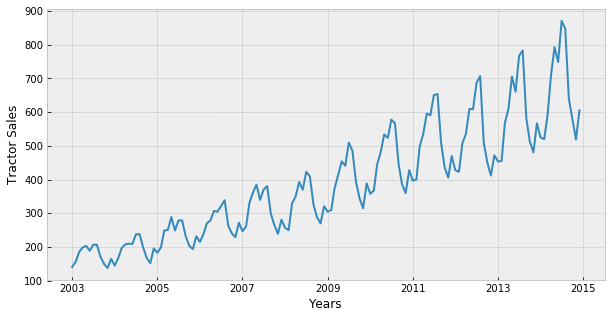

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Now we start with time series decomposition of this data to understand underlying patterns such as **trend**, **seasonality**, **cycle** and **irregular remainder** for tractor sales.

In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is a relatively new unit to notice business cycles. Also in theory, business cycles in traditional businesses are observed  over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years. We will build our model based on the following function:

\begin{equation*}
Y_t = f(Trend_t, Seasonality_t, Remainder_t)
\end{equation*}

**Step 1.1: Trend - Time Series Decomposition**

Now, to begin with let's try to decipher trends embedded in the above tractor sales time series. It is clearly evident that there is an **overall increasing trend** in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:

+ **Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

+ **Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a **Test Statistic** and some **Critical Values** for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

**Moving Average - ** A good analogy for moving average is ironing clothes to remove wrinkles. The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series to produce a steady trend through averaging adjacent values of a time period. Hence, the formula for moving average is:

\begin{equation*}
Moving Average = \frac{\sum_{i=-m}^m Y_{t+i}}{2m}
\end{equation*}

Now, let’s try to remove wrinkles from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

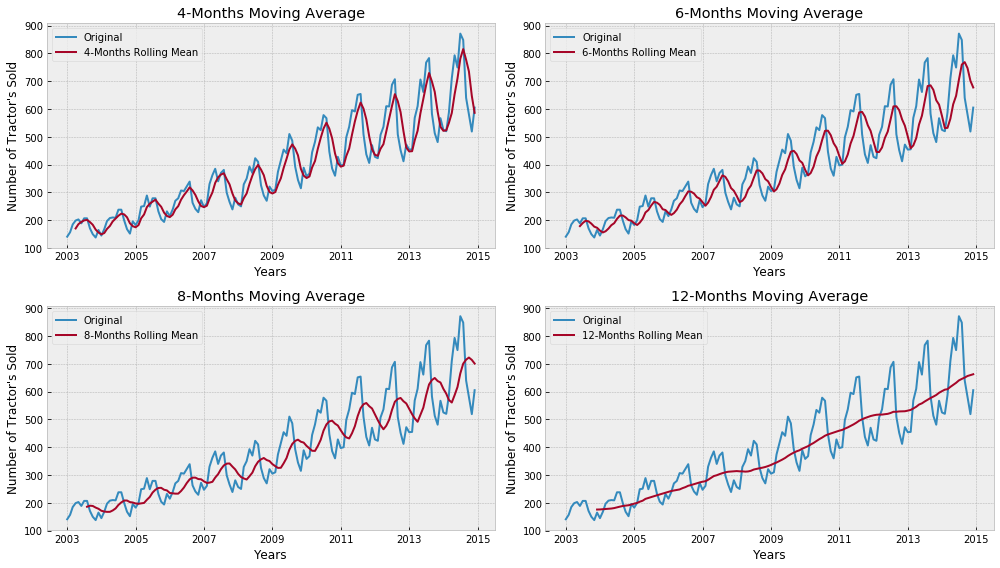

In [10]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

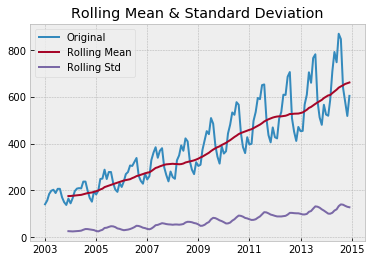

In [11]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Dickey-Fuller Test -** Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [12]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

As we observed while plotting the moving average over months that there is a monhly pattern, now, let’s decipher the seasonal component.

**Step 1.2: Seasonality – Time Series Decomposition**

The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [13]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


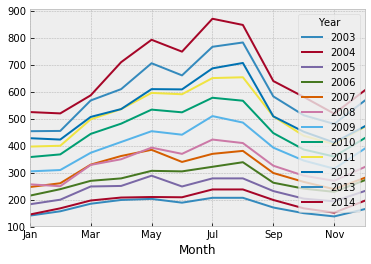

In [14]:
monthly_sales_data.plot()

In [15]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


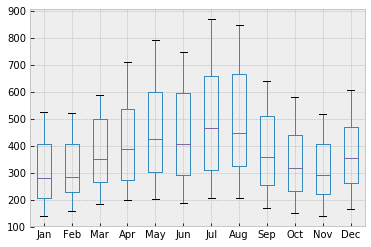

In [16]:
yearly_sales_data.boxplot()

**Important Inferences**

+ The tractor sales have been increasing without fail every year.
+ July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.
+ We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.

**Step 1.3: Irregular Remainder – Time Series Decomposition**

To decipher underlying patterns in tractor sales, we build a multiplicative time series decomposition model with the following equation:

\begin{equation*}
Y_t = Trend_t \times Seasonality_t \times Remainder_t
\end{equation*}

Instead of multiplicative model we could have chosen additive model as well. In that case the equaltion would have been:

\begin{equation*}
Y_t = Trend_t + Seasonality_t + Remainder_t
\end{equation*}

However, it would have made very little difference in terms of conclusion we will draw from this time series decomposition exercise. Additionally, we are also aware that plain vanilla decomposition models like these are rarely used for forecasting. Their primary purpose is to understand underlying patterns in temporal data to use in more sophisticated analysis like Holt-Winters seasonal method or ARIMA.

In [17]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

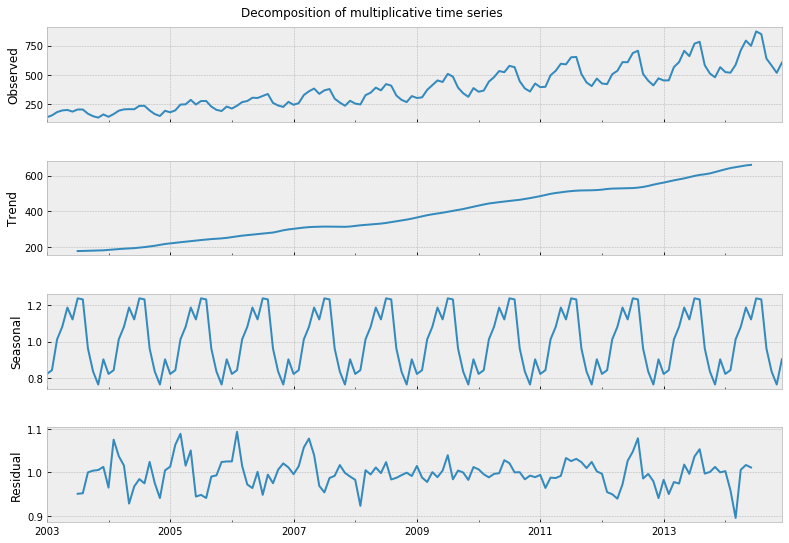

In [18]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

The following are some of our key observations from this analysis:

**1) Trend:** 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.

**2) Seasonality:** As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

\begin{equation*}
Seasonality_t \times Remainder_t = \frac{Y_t}{Trend_t}
\end{equation*}

**3) Irregular Remainder (random):** is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

\begin{equation*}
Remainder_t = \frac{Y_t}{Trend_t \times Seasonality_t}
\end{equation*}

The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.

** ARIMA Modeling**

ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts like a sugar cane through a sugar cane juicer to produce juice-less residual. The sequence of three passes for ARIMA analysis is as following:

**1st Pass of ARIMA to Extract Juice / Information**

**Integrated (I)** – subtract time series with its lagged series to extract trends from the data

In this pass of ARIMA juicer, we extract trend(s) from the original time series data. Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted with it’s lagged series e.g. November’s sales values are subtracted with October’s values to produce trend-less residual series. The formulae for `different` orders of differencing are as follow:

No Differencing (d=0) | $Y'_t = Y_t$

1<sup>st</sup> Differencing (d=1) | $Y'_t = Y_t - Y_{t-1}$

2<sup>nd</sup> Differencing (d=1) | $Y'_t = Y_t - Y_{t-1} - (Y_{t-1} - Y_{t-2}) = Y_t - 2 \times Y_{t-1} + Y_{t-2}$

For example, in the below plot a time series data with a linearly upward trend is displayed. Adjacent to that plot is the 1<sub>st</sub> order differenced plot for the same data. As we can notice after 1st order differencing, trend part of the series is extracted and the difference data (residual) does not display any trend.

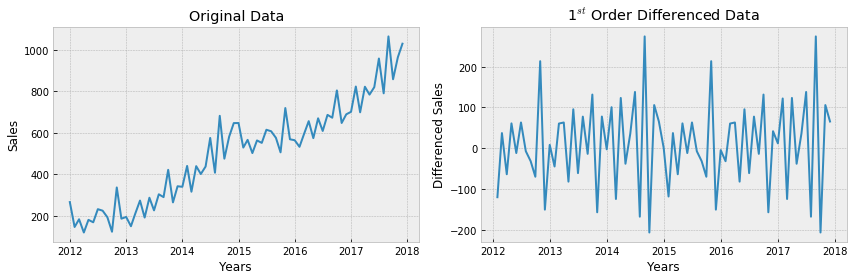

In [19]:
# convert to a dataframe for easy plot and differenciation
random_df = pd.read_csv('data/dummy-sales.csv')
random_df.set_index(pd.date_range(start='2012-01-01', freq='MS', periods=len(random_df)), inplace=True)

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(random_df.index, random_df['Sales'])
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Sales")
axes[0].set_title("Original Data")
axes[1].plot(random_df.index, random_df['Sales'].diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

The residual data of most time series usually become trend-less after the first order differencing which is represented as ARIMA(0,1,0). Notice, AR (p), and MA (q) values in this notation are 0 and the integrated (I) value has order one. If the residual series still has a trend it is further differenced and is called 2nd order differencing. This trend-less series is called stationary on mean series i.e. mean or average value for series does not change over time.

**2nd Pass of ARIMA to Extract Juice / Information**

**AutoRegressive (AR)** – extract the influence of the previous periods’ values on the current period

After the time series data is made stationary through the integrated (I) pass, the AR part of the ARIMA juicer gets activated. As the name auto-regression suggests, here we try to extract the influence of the values of previous periods on the current period e.g. the influence of the September and October’s sales value on the November’s sales. This is done through developing a regression model with the time lagged period values as independent or predictor variables. The general form of the equation for this regression model is shown below.

$Y_t = c + \alpha_1Y_{t-1} + \alpha_2Y_{t-2} + \ldots + \alpha_pY_{t-p} + e_t$

AR model of order 1 i.e. p=1 or ARIMA(1,0,0) is represented by the following regression equation

$Y_t = c + \alpha_1Y_{t-1} + e_t$

**3rd Pass of ARIMA to Extract Juice / Information**

**Moving Average (MA)** – extract the influence of the previous period’s error terms on the current period’s error

Finally, the last component of ARIMA juicer i.e. MA involves finding relationships between the previous periods' error terms on the current period's error term. Keep in mind, this moving average (MA) has nothing to do with moving average we learned about in the previous article on time series decomposition. Moving Average (MA) part of ARIMA is developed with the following simple multiple linear regression values with the lagged error values as independent or predictor variables.

$Y_t = c + e_t + \beta_1e_{t-1} + \beta_2e_{t-2} + \ldots + \beta_qe_{t-q}$

MA model of order 1 i.e. q=1 or ARIMA(0,0,1) is represented by the following regression equation

$Y_t = c + e_t + \beta_1e_{t-1}$

**White Noise & ARIMA**

White noise is a funny thing, if we look at it for long we will start seeing some false patterns. This is because the human brain is wired to find patterns, and at times confuses noises with signals. The biggest proof of this is how people lose money every day on the stock market. This is precisely the reason why we need a mathematical or logical process to distinguish between a white noise and a signal (juice / information). For example, consider the following simulated white noise:

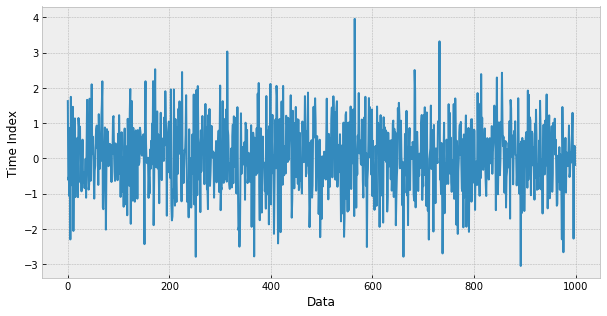

In [20]:
# generate white noise
np.random.seed(1)
# plot of discrete white noise
plt.figure(figsize=(10, 5))
white_noise = np.random.normal(size=1000)
plt.plot(white_noise)
plt.xlabel('Data')
plt.ylabel('Time Index')
plt.show()

If we stare at the above graph for a reasonably long time we may start seeing some false patterns. A good way to distinguish between signal and noise is ACF (*AutoCorrelation Function*). This is developed by finding the correlation between a series of its lagged values. In the following ACF plot, we could see that for lag = 0 the ACF plot has the perfect correlation i.e. $\rho$=1. This makes sense because any data with itself will always have the perfect correlation. However as expected, our white noise doesn't have a significant correlation with its historic values (lag >= 1). The dotted horizontal lines in the plot show the threshold for the insignificant region i.e. for a significant correlation the vertical bars should fall outside the horizontal dotted lines.

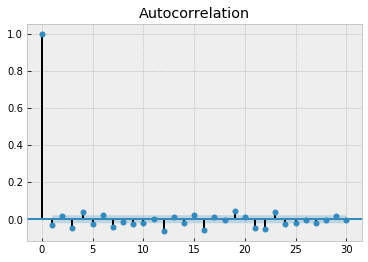

In [21]:
plt.figure()
smt.graphics.plot_acf(white_noise, lags=30, alpha=0.5)
plt.show()

### Step 2: Difference data to make data stationary on mean (remove trend)

Clearly the tractor sales has an upward trend for tractors sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1<sup>st</sup> Differencing (d=1) | $Y'_t = Y_t - Y_{t-1}$

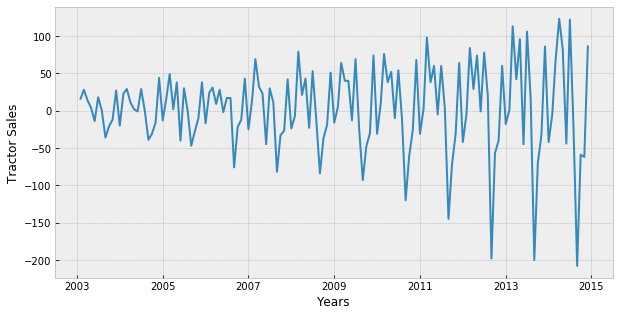

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Okay so the above series is not stationary on variance i.e. variation in the plot is increasing as we move towards the right of the chart. We need to make the series stationary on variance to produce reliable forecasts through ARIMA models.

### Step 3: log transform data to make data stationary on variance

One of the best ways to make a series stationary on variance is through transforming the original series through log transform. We will go back to our original tractor sales series and log transform it to make it stationary on variance. The following equation represents the process of log transformation mathematically:

Log of sales : ${Y_t}^{new} = log_{10}(Y_t)$

Notice, this series is not stationary on mean since we are using the original data without differencing. But now the series looks stationary on variance.

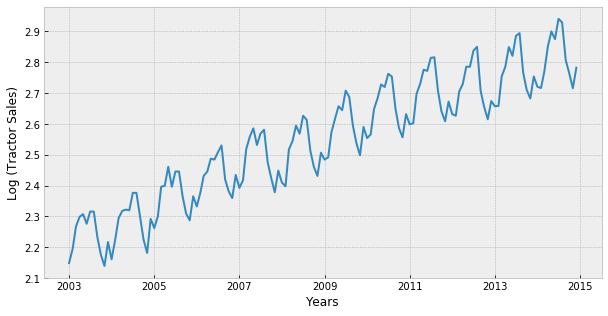

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

### Step 4: Difference log transform data to make data stationary on both mean and variance

Let us look at the differenced plot for log transformed series to reconfirm if the series is actually stationary on both mean and variance.

1<sup>st</sup> Differencing (d=1) of Log of sales : ${Y_t}^{new} = log_{10}(Y_t) - log_{10}(Y_{t-1})$

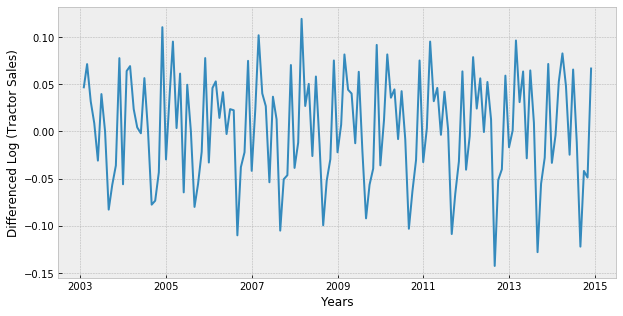

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

Yes, now this series looks stationary on both mean and variance. This also gives us the clue that I or integrated part of our ARIMA model will be equal to 1 as 1st difference is making the series stationary.

### Step 5: Plot ACF and PACF to identify potential AR and MA model

Now, let us create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

In [25]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

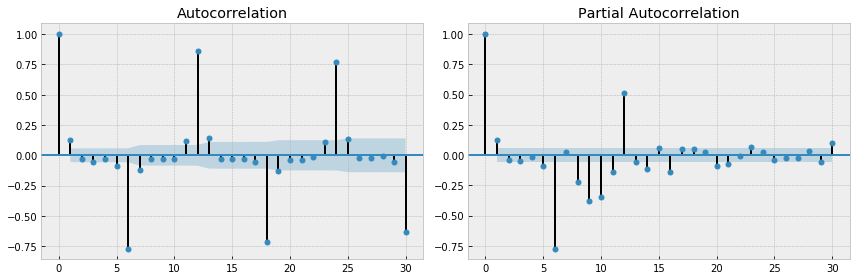

In [26]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

### Step 6: Identification of best fit ARIMA model

In order to fit the time series data with a seasonal ARIMA model, we need to first find the the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest such as AIC or BIC. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Auto arima function in forecast package in R helps us identify the best fit ARIMA model on the fly but in Python we will generate combination of p,d and q to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

This technique is known as "grid search" where we iteratively explore different combinations of parameters. For each such combination of parameters, we try to fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess AIC or BIC score. The model with the best score wins and the parmeters for that model are the optimal parmeters.

In [27]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.7745900509055


The best fit model is selected based on Akaike Information Criterion (AIC) , and Bayesian Information Criterion (BIC) values. The idea is to choose a model with minimum AIC and BIC values. 

**Akaike Information Criterion (AIC)** - AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost). 

$AIC = 2K - 2ln(L)$

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

The model that we got here is different from the one that was discussed in the blog. Let us validate that model with ours how does that perform with statsmodel as well as our model.

In [29]:
# comparing our model with the best model reported in the blog
blog_param_order = (0, 1, 1)
blog_param_seasonal_order = (0, 1, 1, 12)
blog_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=blog_param_order,
                                      seasonal_order=blog_param_seasonal_order,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
blog_results = blog_model.fit()
print("Blog SARIMAX{}x{}12 model - AIC:{}".format(blog_param_order, blog_param_seasonal_order, blog_results.aic))

Blog SARIMAX(0, 1, 1)x(0, 1, 1, 12)12 model - AIC:-702.7798971744214


Our model has a better AIC than the AIC of the best model in the blog. Moreover, the AIC achieved using the blog model parameters received the same AIC score as in the blog. So, the python statsmodel implementation is in sync with R and we are also modelling correctly. 

### Step 7: Predict sales on in-sample date using the best fit ARIMA model

The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [30]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [31]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Thu, 27 Jul 2017   AIC                           -733.775
Time:                                    12:42:15   BIC                           -721.895
Sample:                                01-01-2003   HQIC                          -728.948
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3578      0.069     -5.202      0.000      -0.493      -0.223
ar.S.L12       0.9933      0.006   

In [32]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [33]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0011


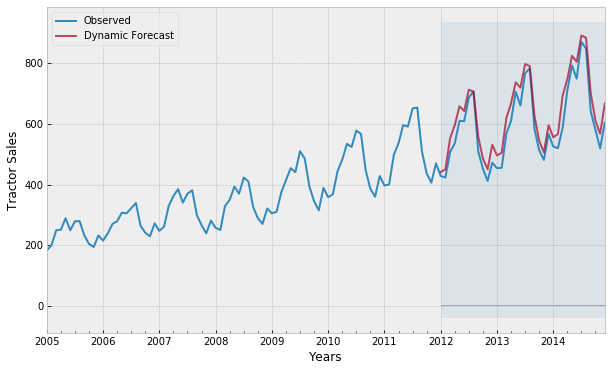

In [34]:
axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

### Step 8: Forecast sales using the best fit ARIMA model

The next step is to predict tractor sales for next 3 years i.e. for 2015, 2016, and 2017 through the above model.

In [35]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [36]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.468015,528.227562,609.623525,528.227562,609.623525
2015-01-01,566.211932,519.989272,616.543397,519.989272,616.543397
2015-02-01,668.847873,607.139743,736.827860,607.139743,736.827860
2015-03-01,755.215566,678.459235,840.655594,678.459235,840.655594
2015-04-01,850.233176,756.627416,955.419322,756.627416,955.419322


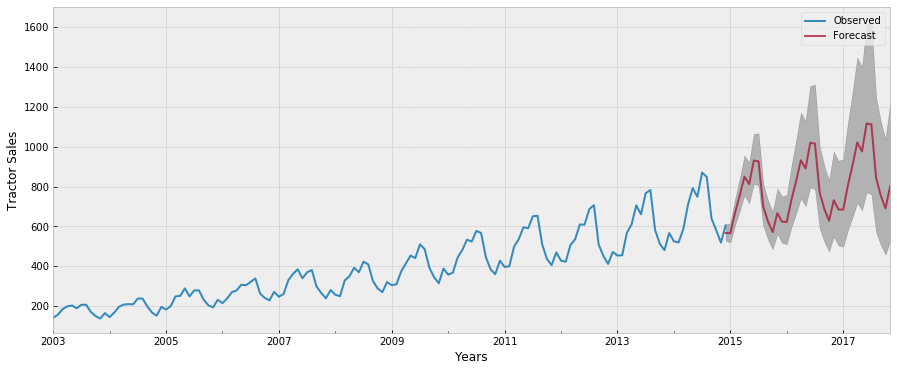

In [37]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

Now, forecasts for a long period of 3 years is an ambitious task. The major assumption here is that the underlining patterns in the time series will continue to stay the same as predicted in the model. A short-term forecasting model, say a couple of business quarters or a year, is usually a good idea to forecast with reasonable accuracy. A long-term model like the one above needs to evaluated on a regular interval of time (say 6 months). The idea is to incorporate the new information available with the passage of time in the model.

### Step 9: Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction

Finally, let’s create an ACF and PACF plot of the residuals of our best fit ARIMA model i.e. ARIMA(0,1,1)(1,0,1)[12].

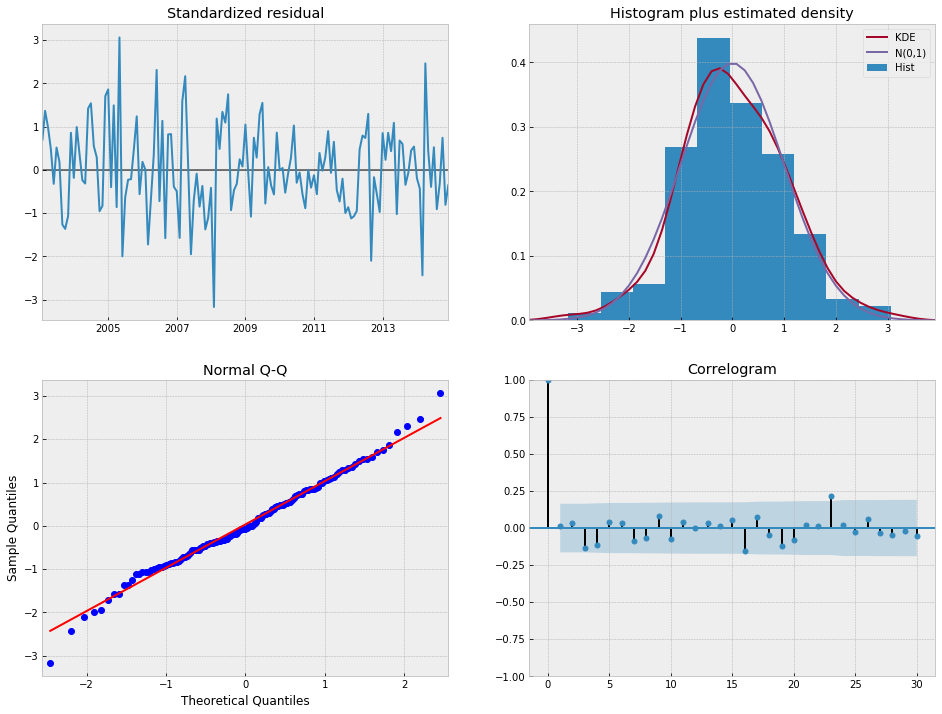

In [38]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

We need to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If it is not that it signifies that the model can be further improved and we repeat the process with the residuals.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

+ The KDE plot of the residuals on the top right is almost similar with the normal distribution.


+ The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.


+ The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.


Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information or juice in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It sems that our ARIMA model is working fine.

### Step 10: Regression with ARIMA Errors (Work in Progress)

For the last 4 years, PowerHorse tractors is  running an expensive marketing and farmer connect program to boost their sales. They are interested in learning the impact of this program on overall sales. As a data science consultant we are helping them with this effort. This is an interesting problem and requires a thorough analysis followed by creative solutions and scientific monitoring mechanism. To begin with we will build models based on regression with ARIMA errors and compare them with the pure play ARIMA model. This analysis will provide some clues towards effectiveness of the marketing program. However, this analysis will not be conclusive for finding shortcomings and enhancements for the program which will require further analysis and creative solutions.

In [39]:
mkt_sales_data = pd.read_csv('data/sales-and-marketing.csv')

# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


To begin with, we plot the following scatter plot of same months marketing expense and tractors sales.

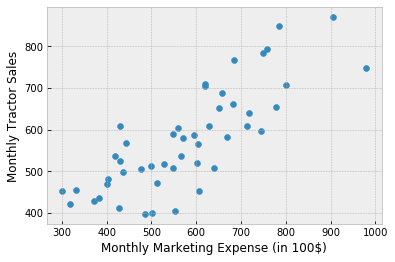

In [40]:
plt.figure()
plt.scatter(x=mkt_sales_data['Marketing Expense'], y=mkt_sales_data['Tractor-Sales'])
plt.xlabel('Monthly Marketing Expense (in 100$)')
plt.ylabel('Monthly Tractor Sales')

In [41]:
print("Correlation for Marketing Data: {}".format(round(mkt_sales_data.corr()['Marketing Expense']['Tractor-Sales'], 2)))

Correlation for Marketing Data: 0.8


This looks promising with quite a high correlation coefficient ($\rho$ > 0.8). However, there is a lurking danger in analyzing non-stationary time series data. Since two uncorrelated series can display high correlation because of time series trend in data. In this case, PowerHorse is a growing company and the latent factor is 'growth' of the company. Hence both its sales and marketing expenses can be on an upward curve independent of each other. To investigat that a better way is to find the correlation between stationary data obtained through differencing of marketing expediture and the trator sales data individually.

The following is the correlation plot for stationary data:

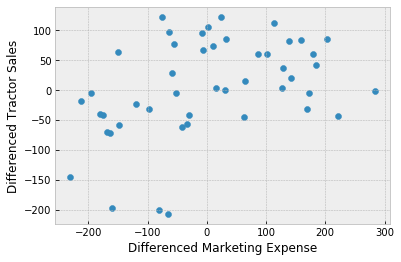

In [42]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

plt.figure()
plt.scatter(x=mkt_sales_data_diff['Marketing Expense'], y=mkt_sales_data_diff['Tractor-Sales'])
plt.xlabel('Differenced Marketing Expense')
plt.ylabel('Differenced Tractor Sales')

In [43]:
print("Correlation for Stationary Data: {}".format(round(mkt_sales_data_diff.corr()['Marketing Expense']['Tractor-Sales'], 2)))

Correlation for Stationary Data: 0.41


Ok, so that near perfect correlation has now disappeared though there is still some correlation in this data ($\rho$ = 0.41). 

Typically, the marketing effort for the previous few months needs to have a good correlation with sales for an effective marketing program. The marketing expense for the last month as displayed below has very little correlation ($\rho$ = 0.17):

In [44]:
len(mkt_sales_data_diff)

47

In [45]:
prev_months_corr_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'][0:46].values,\
                                        mkt_sales_data_diff['Tractor-Sales'][1:47].values)), \
                                     columns=["Previous Month's Differenced Marketing Expense" , 
                                              "Differenced Tractor Sales"])

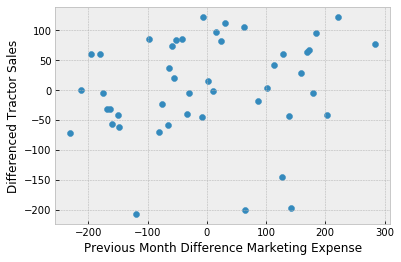

In [46]:
plt.figure()
plt.scatter(x=prev_months_corr_data["Previous Month's Differenced Marketing Expense"], \
            y=prev_months_corr_data["Differenced Tractor Sales"])
plt.xlabel("Previous Month Difference Marketing Expense")
plt.ylabel("Differenced Tractor Sales")
plt.show()

In [47]:
print(
    "Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: {}"\
    .format(round(prev_months_corr_data.corr().iloc[0,1], 2)))

Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: 0.17


The following diagram how the current data can be correlated to the previous months data.

![Previous Months Correlation](images/prev_months_corr.png "Previous Months Correlation")

The correlation for the previous quarter also shows non-existent correlation with sales. Now, let’s build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [48]:
clip_length = len(mkt_sales_data_diff)
clip_length

47

In [49]:
lagged_mkt_exp_diff_sales_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=1)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=2)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=3)[0:clip_length],\
                                        mkt_sales_data_diff['Tractor-Sales'][0:47].values)), \
                                     columns=["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3", "Diff_Sales"])

In [50]:
lagged_mkt_exp_diff_sales_data.set_index(mkt_sales_data_diff.index, inplace=True)
lagged_mkt_exp_diff_sales_data.head(10)

,Diff_Mkt_Exp,Diff_Mkt_Exp_Lag_1,Diff_Mkt_Exp_Lag_2,Diff_Mkt_Exp_Lag_3,Diff_Sales
2011-02-01,15.16,NaN,NaN,NaN,3.0
2011-03-01,-64.71,15.16,NaN,NaN,98.0
2011-04-01,128.07,-64.71,15.16,NaN,38.0
2011-05-01,178.99,128.07,-64.71,15.16,60.0
2011-06-01,-195.41,178.99,128.07,-64.71,-5.0
2011-07-01,101.47,-195.41,178.99,128.07,60.0
2011-08-01,127.30,101.47,-195.41,178.99,3.0
2011-09-01,-230.40,127.30,101.47,-195.41,-145.0
2011-10-01,-164.30,-230.40,127.30,101.47,-72.0
2011-11-01,168.75,-164.30,-230.40,127.30,-31.0


We now want to create different by considering the different lagged marketing expenditure attributes as regressors and investigate whether previous motnh's/quarter's affect the tractor sales or not (in other words if we incoporate the marketing efforts does they lower the AIC score or not. We would be building 4 ARIMA models with regressors ranging from current month to last quarter)

![Models With Regressors](images/models_with_regressors.png "Models With Regressors")

In [51]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 1), q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=True,
                                                 enforce_invertibility=True)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [52]:
#ARIMA Model No Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data["Diff_Mkt_Exp"][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:443.25444780654317
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -217.627
Date:                            Thu, 27 Jul 2017   AIC                            443.254
Time:                                    12:42:19   BIC                            450.391
Sample:                                05-01-2011   HQIC                           445.901
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Diff_Mkt_Exp     0.0233      0.039      0

In [53]:
#ARIMA Model with 1 month Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:445.1400535200924
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -217.570
Date:                            Thu, 27 Jul 2017   AIC                            445.140
Time:                                    12:42:20   BIC                            454.061
Sample:                                05-01-2011   HQIC                           448.448
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0259 

In [54]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:447.07783769953426
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -217.539
Date:                            Thu, 27 Jul 2017   AIC                            447.078
Time:                                    12:42:21   BIC                            457.783
Sample:                                05-01-2011   HQIC                           451.048
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0237

In [55]:
#ARIMA Model with 3 months Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 model - AIC:447.40320160112105
                                 Statespace Model Results                                 
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -216.702
Date:                            Thu, 27 Jul 2017   AIC                            447.403
Time:                                    12:42:24   BIC                            459.893
Sample:                                05-01-2011   HQIC                           452.035
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0111

Comparing the AIC from the various models:

| Models  | No Regressor  | 1 Month Lag Regressor |1 Months Lag Regressor | 3 Months Lag Regressor |
| --------|:-------------:|:---------------------:|:---------------------:|:----------------------:|
| **AIC**     | 443.254       | 445.140               | 447.078               | 447.403            |

Notice AIC, AICc, and BIC values for the plain ARIMA model without marketing expense as predictor variable has lower values of the two models. This indicates that marketing expense is not actually adding value to tractor sales. This is the first indication for the management at PowerHorse to re-evaluate the marketing and farmer connect program. I must point out that evaluation of marketing budgets with a forecasting model like the one we have built is not the best of practices. The best practice is to embed scientific data collection, monitoring, and evaluation mechanism in the design of a marketing program at inception. However, a scientific and well thought out mechanism prior to implementation is often missing in many programs. This is when one could go back in time to use regression with ARIMA error to evaluate effective of marketing programs.

**References:**

Blogs without which this notebook would not have been possible

+ Forecasting & Time Series Analysis – Manufacturing Case Study  by Roopam Upadhyay

    http://ucanalytics.com/blogs/forecasting-time-series-analysis-manufacturing-case-study-example-part-1/
    
    http://ucanalytics.com/blogs/time-series-decomposition-manufacturing-case-study-example-part-2/

    http://ucanalytics.com/blogs/arima-models-manufacturing-case-study-example-part-3/

    http://ucanalytics.com/blogs/step-by-step-graphic-guide-to-forecasting-through-arima-modeling-in-r-manufacturing-case-study-example/

    http://ucanalytics.com/blogs/how-effective-is-my-marketing-budget-regression-with-arima-errors-arimax-case-study-example-part-5/

+ [A Complete Tutorial on Time Series Modeling in R from Analytics Vidhya](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)
+ [A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python) from Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
+ [A Guide to Time Series Visualization with Python 3 by Digital Ocean](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3)
+ [A Guide to Time Series Forecasting with ARIMA in Python 3 by Digital Ocean](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
+ [Time Series Analysis (TSA) in Python - Linear Models to GARCH by Brian Christopher](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)
+ [Seasonal ARIMA with Python by SeanAbu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)